In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('DUQ_hourly.csv', index_col=['Datetime'], parse_dates=['Datetime'], dayfirst=True)

In [3]:
df.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0
2005-12-31 04:00:00,1336.0
2005-12-31 05:00:00,1356.0


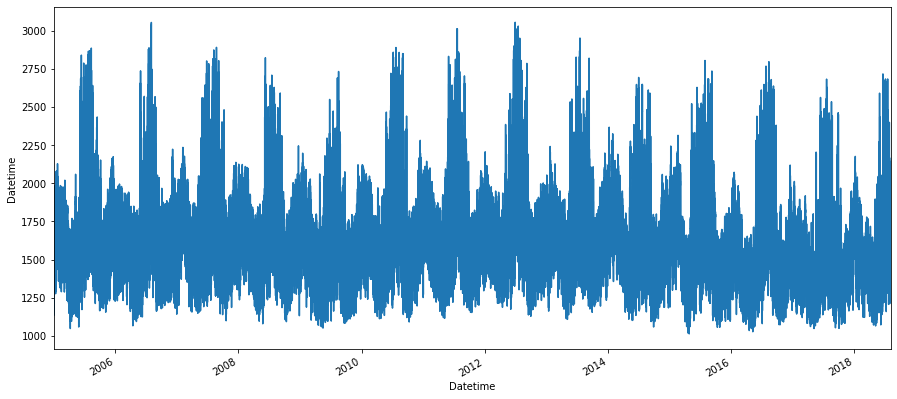

In [4]:
plt.figure(figsize(15,7))
df['DUQ_MW'].plot()
plt.ylabel('Datetime')
pylab.show()

Проверим ряд на стационарность

C:\Users\darya\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\darya\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\darya\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\darya\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWar

 Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

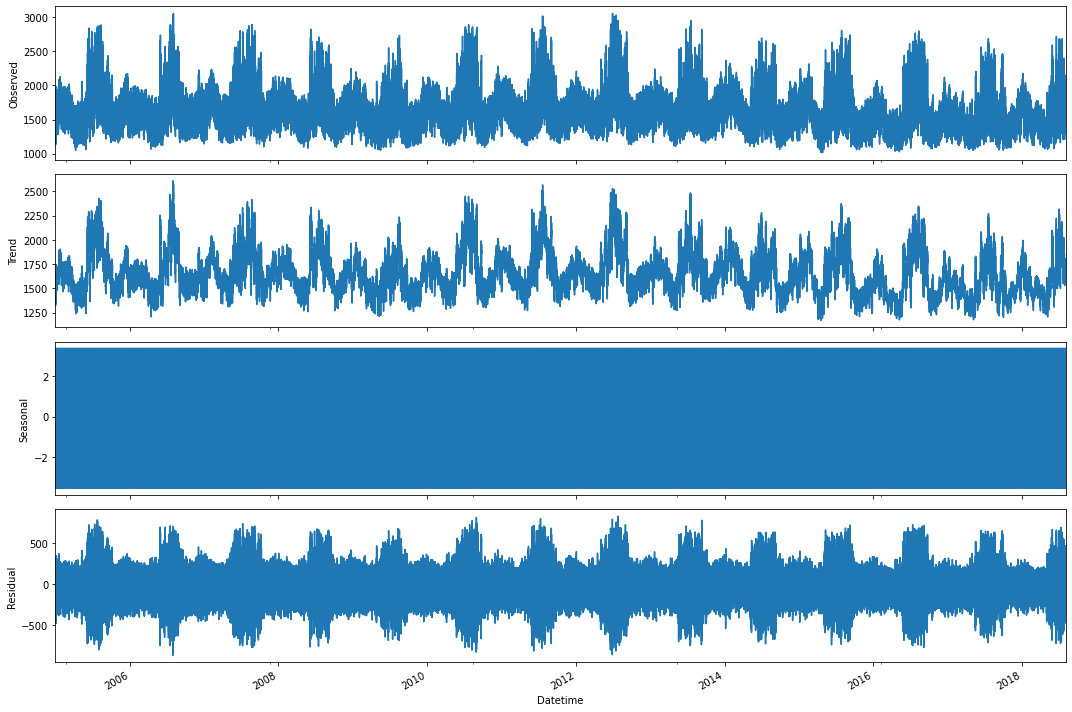

In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['DUQ_MW'], freq = 30).plot()
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['DUQ_MW'])[1])

Использую преобразование Кокса-Бокса для стаблизации дисперсии

Оптимальный параметр преобразования Кокса- Бокса: -0.598402
 Критерий Дики-Фуллера: p=0.000000


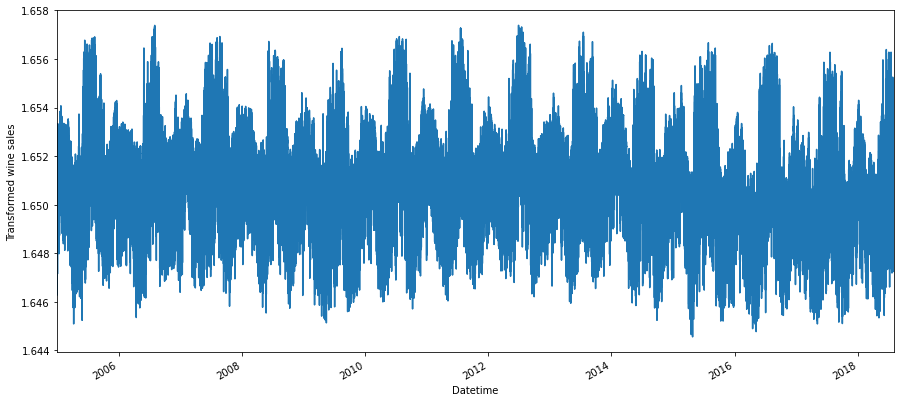

In [7]:
df['Трансформация'], lmbda = stats.boxcox(df['DUQ_MW'])
plt.figure(figsize(15,7))
df['Трансформация'].plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Кокса- Бокса: %f" % lmbda)
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Трансформация'])[1])

C:\Users\darya\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\darya\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\darya\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\darya\Anaconda3\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWar

 Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

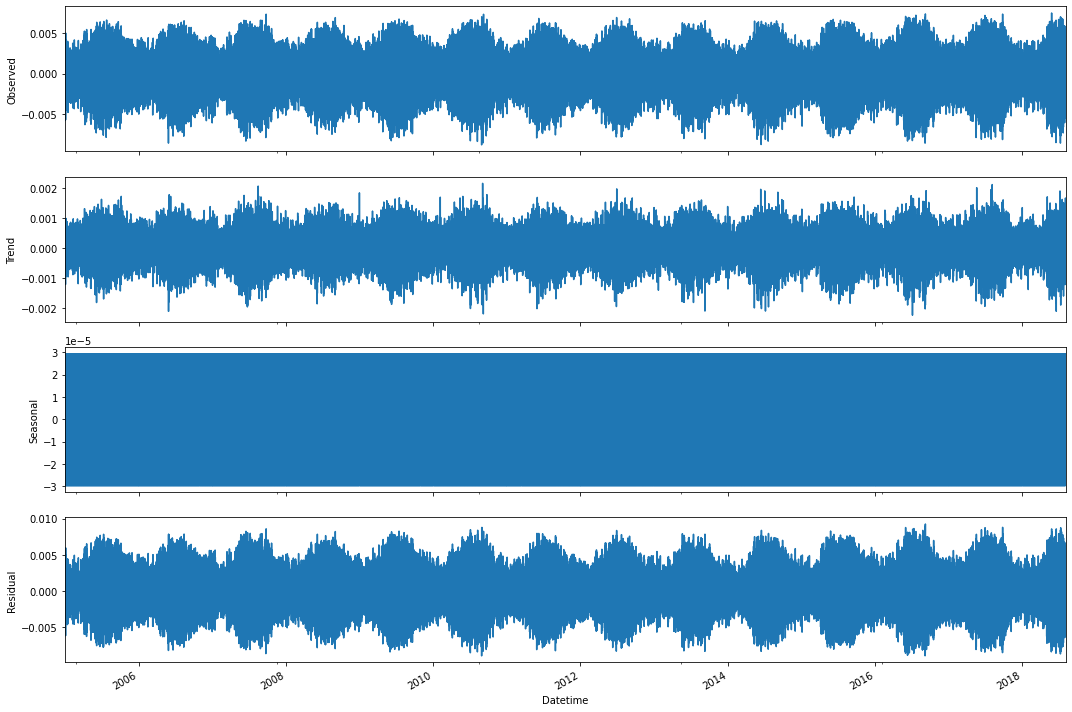

In [8]:
df['Трансформация_2'] = df['Трансформация'] - df['Трансформация'].shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df['Трансформация_2'][12:], freq = 30).plot()
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Трансформация_2'][12:])[1])

Подбор модели

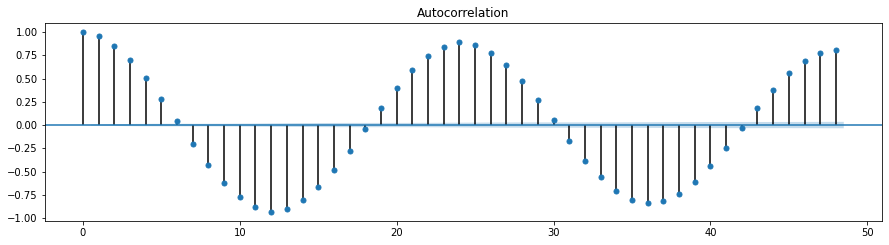

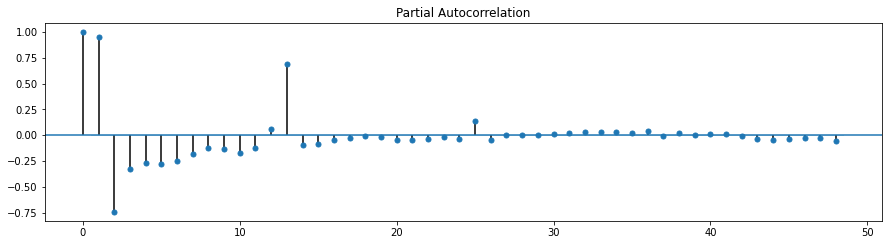

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['Трансформация_2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['Трансформация_2'][13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [10]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df['Трансформация'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохран¤ем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
3  (0, 0, 1, 1) -1.564485e+06
2  (0, 0, 1, 0) -1.564230e+06
5  (0, 1, 0, 1) -1.506220e+06
1  (0, 0, 0, 1) -1.482390e+06
4  (0, 1, 0, 0) -1.398921e+06


In [17]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                      Трансформация   No. Observations:               119068
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood              782245.545
Date:                            Mon, 25 May 2020   AIC                       -1564485.090
Time:                                    16:13:33   BIC                       -1564456.028
Sample:                                         0   HQIC                      -1564476.339
                                         - 119068                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9101      0.001   -971.586      0.000      -0.912      -0.908
ma.S.L12      -0.0131      0.004   

 Критерий —Стьюдента: p=0.980504
 Критерий Дики-Фуллера: p=0.000000


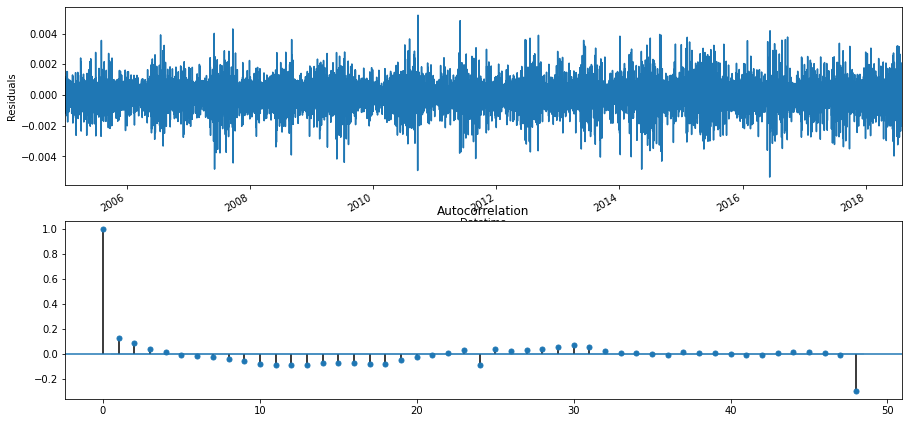

In [18]:

plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print(" Критерий —Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print(" Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

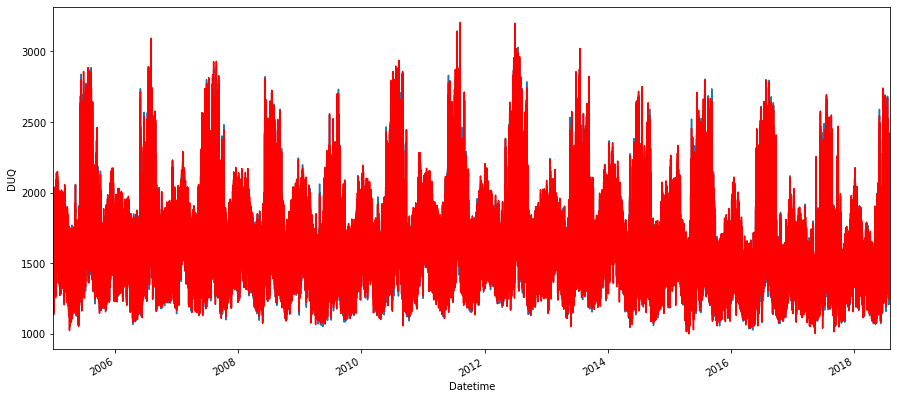

In [19]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df['DUQ_MW'].plot()
df.model[13:].plot(color='r')
plt.ylabel('DUQ')
pylab.show()

In [ ]:
# где-то видимо в решениях опечатка

<Figure size 1080x504 with 0 Axes>

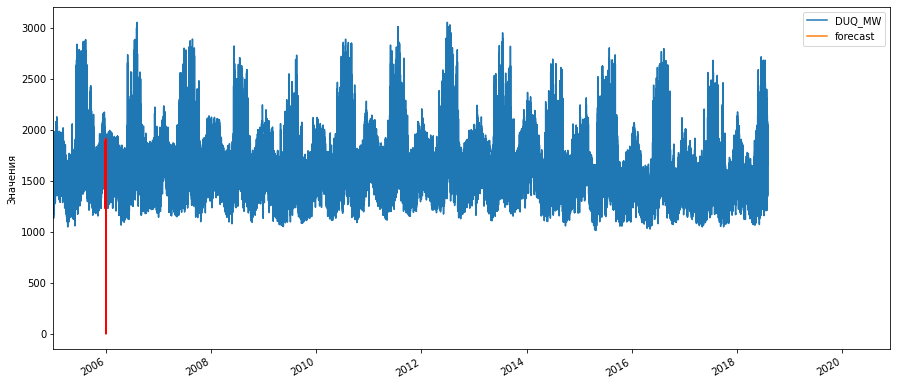

In [24]:
df2 = df[['DUQ_MW']]
date_list = [datetime.datetime.strptime("2018-01-03", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=0, end=211), lmbda)

plt.figure(figsize(15,7))
df2.plot()
df2.forecast.plot(color='r')
plt.ylabel('Значения')
pylab.show()